파일 불러오기

In [19]:
import matplotlib.pyplot as plt

# Plotting
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
plt.show()

In [1]:
import pandas as pd
## 한국경제

df = pd.read_csv("C:/Users/82107/Desktop/동아리/mvo/csv/real_final_sent_score.csv", 
                 usecols=['date', 'sent_score'], 
                 parse_dates=['date'])

## 매일경제

# df = pd.read_csv("C:/Users/82107/Desktop/동아리/mvo/csv/mail_finish_.csv", 
#                  usecols=['date', 'senti'], 
#                  parse_dates=['date'])
# df.rename(columns={'senti': 'sent_score'}, inplace=True)

## 블롬버그

# df = pd.read_csv("C:/Users/82107/Desktop/동아리/mvo/csv/bloomberg.csv", 
#                  usecols=['date', 'senti'], 
#                  parse_dates=['date'])
# df.rename(columns={'senti': 'sent_score'}, inplace=True)

df_senti_date = df.groupby('date').mean().reset_index()
df_senti_month = df.groupby(pd.Grouper(key='date', freq='M')).mean().reset_index()
month_test = 12
for i in range(month_test, len(df_senti_month)):
    S_t_1 = df_senti_month.loc[i, 'sent_score']
    previous_3_months = df_senti_month.loc[i-month_test:i-1, 'sent_score']
    max_prev = previous_3_months.max()
    min_prev = previous_3_months.min()
    
    if S_t_1 > max_prev:
        adjustment_factor = 1
    elif S_t_1 < min_prev:
        adjustment_factor = 0
    else:
        adjustment_factor = (S_t_1 - min_prev) / (max_prev - min_prev)
    
    df_senti_month.loc[i, 'norm_senti'] = adjustment_factor
print(df_senti_month)

         date  sent_score  norm_senti
0  2016-07-31    1.200000         NaN
1  2016-08-31    4.677419         NaN
2  2016-09-30   -2.285714         NaN
3  2016-10-31   -0.307692         NaN
4  2016-11-30    0.033333         NaN
..        ...         ...         ...
90 2024-01-31   -0.194030    0.125679
91 2024-02-29    2.156250    0.464171
92 2024-03-31    3.040323    0.591497
93 2024-04-30    1.924242    0.430757
94 2024-05-31    6.236842    1.000000

[95 rows x 3 columns]


MVO코드 (최적 sharpe ratio로 일단 하긴 했는데 다른 파일 mvo보면 min variance 코드도 있으니까 옮기기만하면 될듯?)

In [8]:
import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice,seed 
from numpy.linalg import inv
import seaborn as sns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
df_return = pd.read_excel("C:/Users/82107/Desktop/동아리/mvo/csv/month_return.xlsx", index_col=0, parse_dates=True)/100
def mvo(df):
    #파라미터 셋팅
    stocks = df.columns
    n_obs, n_assets = df.shape
    NUM_PF = 100000 #number of portfolios to simulate

    #연단위 환산
    periods_per_year = round(df.resample('A').size().mean())
    periods_per_year #전체 기간을 1년 단위로 환산

    #평균 수익률 및 covariance-variance matrix
    mean_returns = (1+df.mean())** periods_per_year - 1
    cov_matrix = df.cov()
    #precision matrix는 covariance matrix의 inverse matrix
    precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks) 
    precision_matrix
    rf_rate = 0
    def portfolio_std(wt, rt=None, cov=None):
        return np.sqrt(wt @ cov @ wt * periods_per_year)

    def portfolio_returns(wt, rt=None, cov=None):
        return (wt @ rt + 1) ** periods_per_year -1

    def portfolio_performance(wt, rt, cov):
        r = portfolio_returns(wt, rt=rt)
        sd = portfolio_std(wt, cov=cov)
        return r, sd
        
    #minimize function
    def neg_sharpe_ratio(weights, mean_ret, cov):
        r, sd = portfolio_performance(weights, mean_ret, cov)
        return -(r - rf_rate) / sd

    def max_sharpe_ratio(mean_ret, cov, short=False):
        seed(42)
        x0 = uniform(0, 1, n_assets) #초기값
        x0 /= np.sum(np.abs(x0))

        return minimize(fun=neg_sharpe_ratio, #제약식
                        x0=x0, #초기값
                        args=(mean_ret, cov),
                        method='SLSQP',
                        bounds=((0, 1),) * n_assets, #weight가 0,1 사이에 오도록
                        constraints = {'type':'eq','fun': lambda x: np.sum(np.abs(x))-1}, #weight의 합이 1
                        options={'maxiter':1e4}) #최대 반복 횟수
                        
    # get max sharpe PF
    max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
    max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)
    # print(f'최적 sharp_ratio의 weight = \n{max_sharpe_pf.x}, \nreturn, std = {max_sharpe_perf}')

    return max_sharpe_pf.x, max_sharpe_perf[0], max_sharpe_perf[1]


def mvo_rf(df):
    #파라미터 셋팅
    stocks = df.columns
    n_obs, n_assets = df.shape
    NUM_PF = 100000 #number of portfolios to simulate


    #연단위 환산
    periods_per_year = round(df.resample('A').size().mean())
    periods_per_year #전체 기간을 1년 단위로 환산

    #평균 수익률 및 covariance-variance matrix
    mean_returns = (1+df.mean())** periods_per_year - 1
    cov_matrix = df.cov() 
    #precision matrix는 covariance matrix의 inverse matrix
    precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks) 
    precision_matrix
    rf_rate = 0.035
    def portfolio_std(wt, rt=None, cov=None):
        asset_weights = wt[:-1]
        return np.sqrt(asset_weights @ cov @ asset_weights * periods_per_year)

    def portfolio_returns(wt, rt=None, cov=None):
        asset_weights = wt[:-1]
        rf_weight = wt[-1]
        return ((asset_weights @ rt + rf_weight * rf_rate + 1) ** periods_per_year) - 1


    def portfolio_performance(wt, rt, cov):
        r = portfolio_returns(wt, rt=rt)
        sd = portfolio_std(wt, cov=cov)
        return r, sd
        
    #minimize function
    def neg_sharpe_ratio(weights, mean_ret, cov):
        r, sd = portfolio_performance(weights, mean_ret, cov)
        return -(r - rf_rate) / sd
    
    def max_sharpe_ratio(mean_ret, cov, short=False):
        seed(42)
        x0 = uniform(0, 1, n_assets+1) #초기값
        x0 /= np.sum(np.abs(x0))

        return minimize(fun=neg_sharpe_ratio,  # 제약식
                        x0=x0,  # 초기값
                        args=(mean_ret, cov),
                        method='SLSQP',
                        bounds=((0, 1),) * (n_assets + 1),  # weight가 0,1 사이에 오도록
                        constraints={'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1},  # weight의 합이 1
                        options={'maxiter': 1e4})  # 최대 반복 횟수

                        
    # get max sharpe PF
    max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
    max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)
    # print(f'최적 sharp_ratio의 weight = \n{max_sharpe_pf.x}, \nreturn, std = {max_sharpe_perf}')

    return max_sharpe_pf.x, max_sharpe_perf[0], max_sharpe_perf[1]


weight, sharpe, std = mvo_rf(df_return)
weight

array([2.82105022e-09, 7.35392569e-09, 5.44350608e-09, 7.86609304e-01,
       9.20433771e-10, 1.07676183e-09, 2.13390673e-01, 5.64405253e-09])

백테스트 코드

In [9]:
def backtest(df, weights, risk_free_weight, start_date, risk_free_rate):
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.DateOffset(months=1)

    df = df[(df.index >= start_date) & (df.index <= end_date)]
    initial_value = 1.0
    portfolio_value = initial_value
    weights = [w * (1 - risk_free_weight) for w in weights]
    weights.append(risk_free_weight)
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/(12)) - 1  
    for date in df.index:
        daily_returns = df.loc[date].values
        daily_returns = list(daily_returns) + [daily_risk_free_rate]
        portfolio_return = sum([weights[i] * daily_returns[i] for i in range(len(weights))])
        portfolio_value *= (1 + portfolio_return)
    
    total_return = (portfolio_value / initial_value - 1) * 100
    return total_return

def backtest2(df, weights, risk_free_weight, start_date, risk_free_rate):
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.DateOffset(months=1)

    df = df[(df.index >= start_date) & (df.index <= end_date)]
    initial_value = 1.0
    portfolio_value = initial_value
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/(12)) - 1  
    
    for date in df.index:
        daily_returns = df.loc[date].values
        daily_returns = list(daily_returns) + [daily_risk_free_rate]
        
        portfolio_return = sum([weights[i] * daily_returns[i] for i in range(len(weights))])
        portfolio_value *= (1 + portfolio_return)
    
    total_return = (portfolio_value / initial_value - 1) * 100
    return total_return


start_date = f'2021-05-05'
backtest2(df_return,weight,0.03,start_date,0.035)

-2.008528121051678

Best weight: [0.3550657996910953, 0.04954291807100525, 0.5953912822378995], Best score: 110.74424019156444


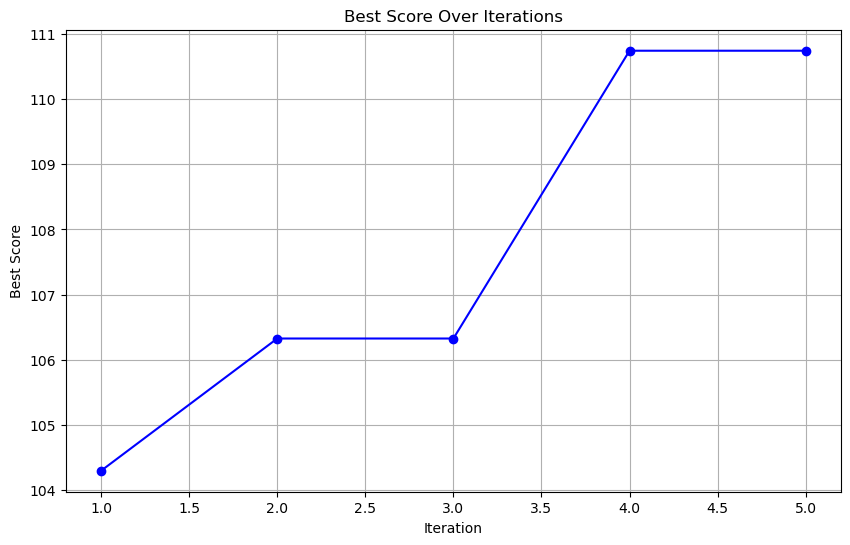

In [4]:
df_return = pd.read_excel("C:/Users/82107/Desktop/동아리/mvo/csv/month_return.xlsx", index_col=0, parse_dates=True)/100
ss = np.random.SeedSequence()
rng = np.random.default_rng(ss)
# 몬테 카를로 법칙을 이용한 weight 뽑기 함수
def weight_select(n_iterations, weight_range, evaluate_model):
    best_weight = None
    best_score = float('-inf')
    scores =[]
    for _ in range(n_iterations):
        weight1 = rng.uniform(weight_range[0], weight_range[1])
        weight2 = rng.uniform(weight_range[0], 1- weight1)
        weight3 = 1-weight1-weight2
        score = evaluate_model(weight1,weight2,weight3)
        
        if score > best_score:
            best_score = score
            best_weight = [weight1,weight2,weight3]
        scores.append(best_score)
    return best_weight, best_score, scores

def for_weight(weight1,weight2,weight3):
    w1 = weight1; w2 = weight2; w3 = weight3; rf_ratio = 0.035; rv_list=[]; results=[]; rv_list2=[]
    for year in range(2017,2019):
        for month in range(1,13):
            start_date = f'{year}-{month}-01'
            df_return_copy = df_return[df_return.index <= start_date].copy()
            df_senti_month_copy = df_senti_month[df_senti_month['date'] <= start_date].copy()
            weight, sharpe, std = mvo(df_return_copy)
            rf_weight = 1-(df_senti_month_copy.iloc[-1]['norm_senti'] * w1 + df_senti_month_copy.iloc[-2]['norm_senti'] * w2 + df_senti_month_copy.iloc[-3]['norm_senti'] * w3)
            revenue = backtest(df_return,weight,rf_weight,start_date,rf_ratio)
            revenue2 = backtest2(df_return,weight,0.035,start_date,rf_ratio)
            rv_list.append(revenue)
            rv_list2.append(revenue2)
            results.append({'date': start_date, 'revenue': revenue, 'rf_weight': rf_weight})
    asset_values1 = [100]  # 초기 자산 값 100
    for rv in rv_list[9:]:
        asset_values1.append(asset_values1[-1] * (rv/100 +1))
    return asset_values1[-1]

# 몬테카를로 방법으로 최적의 가중치 선택
n_iterations = 5
weight_range = (0, 1)
best_weight, best_score, scores = weight_select(n_iterations, weight_range, for_weight)

print(f"Best weight: {best_weight}, Best score: {best_score}")
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), scores, marker='o', linestyle='-', color='b')
plt.title('Best Score Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.grid(True)
plt.show()

In [15]:
from numpy.random import uniform, seed
seed(42)
df_return = pd.read_excel("C:/Users/82107/Desktop/동아리/mvo/csv/month_return.xlsx", index_col=0, parse_dates=True)/100
w1 = best_weight[0]; w2 = best_weight[1]; w3 = best_weight[2]; rf_ratio = 0.035; rv_list=[]; results=[]; rv_list2=[]
w1 = 0.4; w2 = 0.3; w3=0.3
for year in range(2017,2025):
    for month in range(1,13):
        start_date = f'{year}-{month}-01'
        if year == 2024 and month>=6:
            continue
        if year == 2017 and month<=9:
            continue
        df_return_copy = df_return[df_return.index <= start_date].copy()
        df_senti_month_copy = df_senti_month[df_senti_month['date'] <= start_date].copy()
        weight, sharpe, std = mvo(df_return_copy)
        rf_weight = 1-(df_senti_month_copy.iloc[-1]['norm_senti'] * w1 + df_senti_month_copy.iloc[-2]['norm_senti'] * w2 + df_senti_month_copy.iloc[-3]['norm_senti'] * w3)
        revenue = backtest(df_return,weight,rf_weight,start_date,rf_ratio)
        weight2, sharpe2, std2 = mvo_rf(df_return_copy)
        revenue2 = backtest2(df_return,weight2,0.035,start_date,rf_ratio)
        rv_list.append(revenue)
        rv_list2.append(revenue2)
        results.append({'date': start_date, 'revenue': revenue, 'rf_weight': rf_weight})
asset_values1 = [100]  # 초기 자산 값 100
for rv in rv_list[9:]:
    asset_values1.append(asset_values1[-1] * (rv/100 +1))

df_results = pd.DataFrame(results)
df_senti_month['date'] = pd.to_datetime(df_senti_month['date'])
df_results['date'] = pd.to_datetime(df_results['date'])
df_senti_month['year_month'] = df_senti_month['date'].dt.to_period('M')
df_results['year_month'] = df_results['date'].dt.to_period('M')
df_merged = pd.merge(df_results, df_senti_month, on='year_month', how='left')
df_merged.drop(columns='year_month',inplace=True)
df_merged.drop(columns='date_y',inplace=True)
df_merged.head(50)

C:\Users\82107\AppData\Local\Temp\ipykernel_20620\808009457.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - rf_rate) / sd
C:\Users\82107\AppData\Local\Temp\ipykernel_20620\808009457.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - rf_rate) / sd
c:\Users\82107\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\82107\AppData\Local\Temp\ipykernel_20620\808009457.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - rf_rate) / sd


,date_x,revenue,rf_weight,sent_score,norm_senti
0,2017-10-01,2.275968,0.579327,7.056604,1.000000
1,2017-11-01,1.177673,0.436870,3.838235,0.564270
2,2017-12-01,1.952808,0.397114,0.447368,0.105185
3,2018-01-01,5.714055,0.488645,2.315068,0.358050
4,2018-02-01,-2.423076,0.655943,-1.500000,0.000000
5,2018-03-01,0.447311,0.861029,1.301587,0.327418
6,2018-04-01,-0.939886,0.761618,0.628205,0.248721
7,2018-05-01,-0.305476,0.802286,0.777778,0.266201
8,2018-06-01,-1.469033,0.720678,-0.282609,0.142275
9,2018-07-01,-0.819961,0.788613,-3.077922,0.000000


133.12039814029004


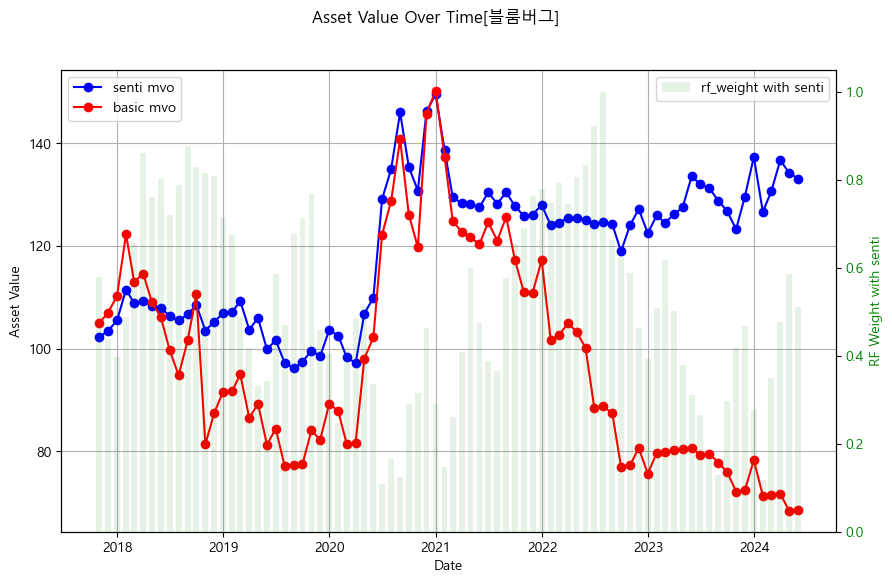

In [20]:
import matplotlib.pyplot as plt
asset_values1 = [100]  # 초기 자산 값 100
for rv in rv_list:
    asset_values1.append(asset_values1[-1] * (rv/100 +1))
print(asset_values1[-1])
asset_values2 = [100]  # 초기 자산 값 100
for rv in rv_list2:
    asset_values2.append(asset_values2[-1] * (rv/100 + 1))

# 날짜 생성 (rv_list 길이에 맞게)
dates = pd.date_range(start='2017-10-01', periods=len(asset_values1)-1, freq='M')
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축
ax1.plot(dates, asset_values1[1:], marker='o', linestyle='-', color='b', label='senti mvo')
ax1.plot(dates, asset_values2[1:], marker='o', linestyle='-', color='r', label='basic mvo')
ax1.set_xlabel('Date')
ax1.set_ylabel('Asset Value', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# 두 번째 y축
ax2 = ax1.twinx()
bar_width = 20  # 바의 너비를 조정
ax2.bar(dates, df_merged['rf_weight'], alpha=0.1, color='g', width=bar_width, label='rf_weight with senti')
ax2.set_ylabel('RF Weight with senti', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# 제목 및 범례 추가
fig.suptitle('Asset Value Over Time[블룸버그]')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그리드 추가
ax1.grid(True)

plt.show()

In [17]:
import numpy as np
import pandas as pd

# 샤프 비율 계산 함수
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    annualized_excess_return = np.mean(excess_returns) * 12
    annualized_std_dev = np.std(excess_returns) * np.sqrt(12)
    sharpe_ratio = annualized_excess_return / annualized_std_dev
    return sharpe_ratio

# 최대 낙폭 계산 함수
def calculate_max_drawdown(asset_values):
    peak = np.maximum.accumulate(asset_values)
    drawdown = (asset_values - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

# 자산 가치 계산
asset_values1 = [100]
for rv in rv_list:
    asset_values1.append(asset_values1[-1] * (rv / 100 + 1))

asset_values2 = [100]
for rv in rv_list2:
    asset_values2.append(asset_values2[-1] * (rv / 100 + 1))

# 자산 가치 시리즈로 변환
asset_values1 = np.array(asset_values1)
asset_values2 = np.array(asset_values2)

# 수익률 계산
returns1 = np.diff(asset_values1) / asset_values1[:-1]
returns2 = np.diff(asset_values2) / asset_values2[:-1]

# 샤프 비율 계산
sharpe_ratio1 = calculate_sharpe_ratio(returns1)
sharpe_ratio2 = calculate_sharpe_ratio(returns2)

# 최대 낙폭 계산
max_drawdown1 = calculate_max_drawdown(asset_values1)
max_drawdown2 = calculate_max_drawdown(asset_values2)

print(f"Sharpe Ratio (Senti MVO): {sharpe_ratio1:.4f}")
print(f"Sharpe Ratio (Basic MVO): {sharpe_ratio2:.4f}")
print(f"Maximum Drawdown (Senti MVO): {max_drawdown1:.4f}")
print(f"Maximum Drawdown (Basic MVO): {max_drawdown2:.4f}")

Sharpe Ratio (Senti MVO): 0.3741
Sharpe Ratio (Basic MVO): -0.0937
Maximum Drawdown (Senti MVO): -0.2046
Maximum Drawdown (Basic MVO): -0.5445
